### Yonatan Klausner, Jonathan Rawson, and Yair Fax 
## Final Project - HustleBall

The Moneyball theory is fairly simple: Using statistical analysis, small-market teams (i.e. teams who do not spend a lot of money) can compete by buying assets that are undervalued by other teams and selling ones that are overvalued by other teams.
The key to Moneyball is figuring out how to know when a player is "undervalued". Here is a [link](http://grantland.com/features/the-economics-moneyball/) to read more about Moneyball.

For our project, we will be looking at statistics in the National Basketball Association (NBA). 
Among other statistics, we will mainly be looking at statistics that involve some sort of hustling. 
These statistics include screen assists, deflections, loose balls recovered, charges drawn, contested shots, which we will explain in detail below. 
We would like to find some sort of correlation between a hustle score that we calculate ourselves and other statistics.  Ideally, our findings will help teams go after specific players due to hustle scores. 

In [95]:
# Imports needed for project 
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
import requests
import pandas as pd
import numpy as np
import pylab as pl
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
figsize(14, 7)
from sklearn.linear_model import LinearRegression
import seaborn as sns

# hustle stat - average mph, miles run, balls deflected, contested shots, stats per minute (steals, o rebounds, feet), 
# jump balls, Loose balls recovered, boxouts, screen assists, charges, team, average salary, all nba or all star teams 
# https://stats.nba.com/players/speed-distance/?sort=AVG_SPEED&dir=1

# To do:
# 1) change the way calculate hustle score 
#        a) add in distance and speed (https://stats.nba.com/players/speed-distance/?sort=DIST_MILES_DEF&dir=1&Season=2017-18&SeasonType=Regular%20Season)
# 2) change up scatter plots 
# 3) sort by position
# 4) trends over time - playoff teams, non-playoff teams, championship teams
# 5) predict current season outcomes
# 6) more detailed comparisons with wins
# 7) look at specific player hustle in a team as correlated with wins
# 8) ML 

# Problems:
# 1) Jrue Holiday 


# Reminders: 
# 1) GP >= 40 make sure not for current season


## Part 1: Get Data
In this section we get all the data that we will be using for our project.  
In the end, we will have five preliminary tables which we will explain in depth later on.

### Step 1: Define Functions for Getting Different Data

These functions get statistics from NBA.com. We use an automated browser ([link](https://webkit.org/blog/6900/webdriver-support-in-safari-10/) to read more) instead of a simple get request because the HTML is not fully populated in the request. The scripts on the page populate the table's data. We use javascript in the browser to edit elements of the page so that we can "click" them to display the full table. We then pull the HTML from the page and pass it to Pandas to create a dataframe.

In [96]:
def getHustleStats(year):
    return getYearStats("https://stats.nba.com/players/hustle/?sort=MIN&dir=-1&Season=" + year + "&SeasonType=Regular%20Season", year)

def getRegularStats(year):
    return getYearStats("https://stats.nba.com/leaders/?Season=" + year + "&SeasonType=Regular%20Season", year)

def getYearStats(url, year):
    # Use an automated browser so that the webpage is rendered properly
    browser = webdriver.Safari()
    browser.get(url)
    
    # Edit HTML so that we can get the whole table
    browser.execute_script('document.getElementsByClassName("stats-table-pagination__select")[0].setAttribute("id", "btn")')
    browser.execute_script('document.getElementById("btn").children[0].setAttribute("id", "select-all")')
    nextButton = browser.find_element_by_id('btn')
    allButton = browser.find_element_by_id('select-all')
    
    # Click on buttons to get whole table
    nextButton.click()
    allButton.click()
    
    # Get HTML and parse
    innerHTML = browser.execute_script("return document.body.innerHTML")
    root = BeautifulSoup(innerHTML, "lxml")
    table = pd.read_html(str(root.find("table")))
    table = table[0]
    
    # Add year column for later table merging
    table['year'] = year
    browser.close()
    return table

This function uses a simple get request for a specific year to get data about players' positions.

In [97]:
def getPositions(year):
    url = "https://www.basketball-reference.com/leagues/NBA_" + str(year) + "_per_game.html"
    r = requests.get(url)
    root = BeautifulSoup(r.content, "lxml")
    data = root.find("table")
    positions_table = pd.read_html(str(data))[0]
    positions_table['year'] = str(year - 1) + "-" + str(year - 2000)
    return positions_table

These functions read simple csv files stored on disk.

In [98]:
def getTeams(filename, year):
    teamTable = pd.read_csv(filename)
    teamTable['year'] = year
    return teamTable

def getSalaries(filename):
    salaryTable = pd.read_csv(filename)
    return salaryTable

### Step 2: Get Hustle Data on Players
This data consists of several statistics that are related to player hustling (see where we got the data from [here](https://stats.nba.com/players/hustle/?sort=MIN&dir=1&Season=2016-17&SeasonType=Regular%20Season)).  The statistics we will use from this data are:  

1. **Screen assists** - a screen is a blocking move by an offensive player, by standing beside or behind a defender, to free a teammate to shoot, receive a pass, or drive in to score. A screen assist is a screen that directly leads to a made field goal.  

2. **Deflections** - a deflection occurs when a defensive player redirects the intended direction of the ball.

3. **Loose Balls Recovered** - a loose ball is when neither team is in control of the ball.  A loose ball recovered is when a player recovers a loose ball.   

4. **Charges Drawn** - a charge, or player-control foul, occurs when a dribbler charges into a defender who has already established his position.  A drawn charge is when a defender takes a charge on an offensive player, meaning the defensive player is in position and the offensive player charges into him.  

5. **Contested Shots** - a contested shot is when a defender is within 4 ft of the person shooting.   

This function is used in cleaning our data. We get rid of any relevant non alphabetical characters as well as some specific suffixes. We do this to make sure that different tables have the same values for Players' names. For example, we want C.J. Watson to match CJ Watson, John Lucas III to match John Lucas, and Kelly Oubre Jr. to match Kelly Oubre.

In [99]:
def stripChars(series):
    return series.str.replace('Jr\.', '').str.replace('.', '').str.replace(',', '').str.replace('III', '').str.replace('II', '').str.replace('IV', '').str.rstrip()

In [100]:
hustle16_17 = getHustleStats("2016-17") 
hustle17_18 = getHustleStats("2017-18")

In [101]:
hustleStats = hustle16_17.append(hustle17_18)
hustleStats['Player'] = stripChars(hustleStats['Player'])
hustleStats.head()

,Player,TEAM,AGE,GP,MIN,ScreenAssists,ScreenAssists PTS,Deflections,OFF Loose BallsRecovered,DEF Loose BallsRecovered,Loose BallsRecovered,% Loose BallsRecovered OFF,% Loose BallsRecovered DEF,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year
0,Danuel House,WAS,24,1,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-17
1,John Lucas,MIN,34,5,2.1,0.0,0.0,0.8,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,2016-17
2,Larry Sanders,CLE,28,5,2.5,0.2,0.4,0.2,0.0,0.0,0.2,0.0,0.0,0.0,1.4,0.0,1.4,2016-17
3,Steve Novak,MIL,34,8,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.1,0.5,2016-17
4,Brice Johnson,LAC,23,3,3.1,0.3,1.0,0.7,0.0,0.0,0.0,0.0,0.0,0.0,1.3,0.3,1.7,2016-17


### Step 3: Get Data for Regular Statistics on Players 
This data consists of several common, player statistics such as **MIN** (minutes per game), **PTS** (points per game), **FGM** (field goals made per game), **REB** (rebounds per game), etc. (see where we got the data from [here](https://stats.nba.com/leaders/?Season=2016-17&SeasonType=Regular%20Season))

In [102]:
regular16_17 = getRegularStats("2016-17") 
regular17_18 = getRegularStats("2017-18")
regularStats = regular16_17.append(regular17_18)
regularStats.head()

,#,Player,GP,MIN,PTS,FGM,FGA,FG%,3PM,3PA,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,EFF,year
0,1,Russell Westbrook,81,34.6,31.6,10.2,24.0,42.5,2.5,7.2,...,84.5,1.7,9.0,10.7,10.4,1.6,0.4,5.4,33.8,2016-17
1,2,James Harden,81,36.4,29.1,8.3,18.9,44.0,3.2,9.3,...,84.7,1.2,7.0,8.1,11.2,1.5,0.5,5.7,32.4,2016-17
2,3,Isaiah Thomas,76,33.8,28.9,9.0,19.4,46.3,3.2,8.5,...,90.9,0.6,2.1,2.7,5.9,0.9,0.2,2.8,24.7,2016-17
3,4,Anthony Davis,75,36.1,28.0,10.3,20.3,50.5,0.5,1.8,...,80.2,2.3,9.5,11.8,2.1,1.3,2.2,2.4,31.1,2016-17
4,5,DeMar DeRozan,74,35.4,27.3,9.7,20.9,46.7,0.4,1.7,...,84.2,0.9,4.3,5.2,3.9,1.1,0.2,2.4,22.7,2016-17


### Step 4: Get Data for Positions of Players
This data consists of the positions for each player.  The five positions are:
1. **PG** - point guard
2. **SG** - shooting guard
3. **SF** - small forward 
4. **PF** - power forward
5. **C** - center

Typically, the **point guard** is the leader of the team when on the court. Being the point guard requires polished ball handling skills and the ability to facilitate the team during a play. The **shooting guard** is generally the best shooter and is usually capable of shooting from farther distances. Generally, they also have good ball-handling skills. The **small forward** often has an aggressive approach to the basket on offense. The **power forward** and the center are usually called "low post" players. They often act as their team's primary rebounders and shot blockers, and also generally get the ball closer to the hoop to take inside shots. The **center** is typically the larger of the two. To read more about the different positions in basketball, please click this [link](https://en.wikipedia.org/wiki/Basketball_positions).

In [103]:
positions16_17 = getPositions(2017)[['Player', 'Pos', 'year']]
positions17_18 = getPositions(2018)[['Player', 'Pos', 'year']]

In [104]:
positionsTable = positions16_17.append(positions17_18)
positionsTable.head()

,Player,Pos,year
0,Alex Abrines,SG,2016-17
1,Quincy Acy,PF,2016-17
2,Quincy Acy,PF,2016-17
3,Quincy Acy,PF,2016-17
4,Steven Adams,C,2016-17


### Step 5: Get Data for Team Wins 

This data consists of team statistics such as wins, losses, home record, road record, etc.  
We use this data to get the number of wins for a team in a given year

In [105]:
teamsWins16_17 = getTeams('teams_2016_2017.csv', '2016-17') 
teamsWins17_18 = getTeams('teams_2017_2018.csv', '2017-18') 
teamsWins16_17.head()

,Team,W,L,Win%,GB,Conf,Div,Home,Road,OT,Last 10,Streak,year
0,BOS,53,29,0.646,0,36-16,11-5,30-11,23-18,2-1,7-3,W 3,2016-17
1,CLE,51,31,0.622,2,35-17,8-8,31-10,20-21,3-4,4-6,L 4,2016-17
2,TOR,51,31,0.622,2,34-18,14-2,28-13,23-18,3-1,8-2,W 4,2016-17
3,WAS,49,33,0.598,4,32-20,8-8,30-11,19-22,4-3,5-5,L 1,2016-17
4,ATL,43,39,0.524,10,30-22,6-10,23-18,20-21,5-0,6-4,L 1,2016-17


### Step 6: Get Data for Salaries of Players

This data consists of player salaries ([link](https://data.world/datadavis/nba-salaries)). 

In [106]:
salaryTable = getSalaries('player_salaries.csv')
salaryTable.head()

,Player,salary,season_end,year,team,team_name
0,Moses Malone,2406000,1991,1990,ATL,Atlanta Hawks
1,Dominique Wilkins,2065000,1991,1990,ATL,Atlanta Hawks
2,Jon Koncak,1550000,1991,1990,ATL,Atlanta Hawks
3,Doc Rivers,895000,1991,1990,ATL,Atlanta Hawks
4,Rumeal Robinson,800000,1991,1990,ATL,Atlanta Hawks


## Part 2: Clean Data
After getting all the data needed for our project, we need to clean the data so that we are able to use each table easily (short, informative [read](https://medium.com/datadriveninvestor/data-cleaning-for-data-scientist-363fbbf87e5f)).   
First, we merge the hustleStats table and the positionsTable on the player and year columns in order to add the positions to the hustleStats table.  
We then print out any players in the merged table with a null position. 

In [107]:
hustleStatsTemp = pd.merge(hustleStats, positionsTable, on=['Player', 'year'], how='left')
hustleStatsTemp[pd.isnull(hustleStatsTemp['Pos'])]

,Player,TEAM,AGE,GP,MIN,ScreenAssists,ScreenAssists PTS,Deflections,OFF Loose BallsRecovered,DEF Loose BallsRecovered,Loose BallsRecovered,% Loose BallsRecovered OFF,% Loose BallsRecovered DEF,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos
1,John Lucas,MIN,34,5,2.1,0.0,0.0,0.8,0.0,0.0,0.2,0.0,0.0,0.00,0.0,0.0,0.0,2016-17,NaN
6,RJ Hunter,CHI,23,3,3.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.3,0.3,0.7,2016-17,NaN
21,CJ Wilcox,ORL,26,22,4.9,0.0,0.0,0.2,0.0,0.0,0.1,0.0,0.0,0.05,0.5,0.6,1.1,2016-17,NaN
43,AJ Hammons,DAL,24,22,7.4,1.0,2.3,0.2,0.0,0.0,0.1,0.0,0.0,0.00,2.0,0.4,2.4,2016-17,NaN
94,KJ McDaniels,BKN,24,49,10.3,0.0,0.1,0.5,0.0,0.0,0.3,0.0,0.0,0.00,1.4,1.0,2.5,2016-17,NaN
156,Juancho Hernangomez,DEN,21,62,13.6,0.3,0.7,0.7,0.0,0.0,0.5,0.0,0.0,0.00,3.1,1.7,4.7,2016-17,NaN
229,CJ Watson,ORL,33,62,16.3,0.1,0.1,1.5,0.0,0.0,0.4,0.0,0.0,0.06,1.2,1.5,2.7,2016-17,NaN
242,Taurean Prince,ATL,23,59,16.6,0.1,0.2,1.4,0.0,0.0,0.6,0.0,0.0,0.05,2.9,2.4,5.2,2016-17,NaN
273,Nene,HOU,34,67,17.9,2.8,6.5,1.5,0.0,0.0,0.7,0.0,0.0,0.15,4.9,1.7,6.6,2016-17,NaN
307,DJ Augustin,ORL,29,78,19.7,0.3,0.8,0.7,0.0,0.0,0.7,0.0,0.0,0.12,1.3,1.8,3.1,2016-17,NaN


As seen above, there are a few players whose position was not set properly.  
After looking closely into each case, we realized what was going wrong for each of them.
1. For a number of the players above, in one table they will have a roman numeral added to the end of their name (e.g. "II") whereas in the other table it will not have the roman numeral.
2. Some players in one table have suffixes such as "Jr." whereas in the other table they do not have those suffixes. 
3. A number of players will have dots in their names in one table (e.g. D.J.) and not in the other table (e.g. DJ). 
4. Taurean Prince - in one table he was named "Taurean Prince" and in the other table it had "Taurean Waller-Prince".
5. Nene - in one table he was named "Nene" and in the other table it had "Nene Hilario".  

First, we dropped all duplicated rows with the same player and year.   
Then we stripped certain characters in player names such as "Jr.", "I", and "II" because one table had "Jr.", "I", and "II" and the other did not.  Therefore, when merging the tables on the player names, the merge took those players has two different players as opposed to the same player.  
Next, we took care of Nene and Taurean Prince cases by renaming them in the table. 

In [108]:
positionsTable = positionsTable.drop_duplicates(subset=['Player', 'year'])
positionsTable['Player'] = stripChars(positionsTable['Player'])
positionsTable.loc[positionsTable['Player'] == 'Nene Hilario', 'Player'] = 'Nene'
positionsTable.loc[positionsTable['Player'] == 'Taurean Waller-Prince', 'Player'] = 'Taurean Prince'
positionsTable.head()

,Player,Pos,year
0,Alex Abrines,SG,2016-17
1,Quincy Acy,PF,2016-17
4,Steven Adams,C,2016-17
5,Arron Afflalo,SG,2016-17
6,Alexis Ajinca,C,2016-17


After cleaning the data some more, we then merge the hustleStats table and the postionsTable again.  
We then print the rows in the hustleStats that have a null position. 

In [109]:
hustleStats = pd.merge(hustleStats, positionsTable, on=['Player', 'year'], how='left')
hustleStats[pd.isnull(hustleStats['Pos'])]

,Player,TEAM,AGE,GP,MIN,ScreenAssists,ScreenAssists PTS,Deflections,OFF Loose BallsRecovered,DEF Loose BallsRecovered,Loose BallsRecovered,% Loose BallsRecovered OFF,% Loose BallsRecovered DEF,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos
134,Juancho Hernangomez,DEN,21,62,13.6,0.3,0.7,0.7,0.0,0.0,0.5,0.0,0.0,0.00,3.1,1.7,4.7,2016-17,NaN
492,Vincent Hunter,MEM,23,4,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.5,1.0,2017-18,NaN
552,Walter Lemon,NOP,25,5,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.4,0.2,1.6,2017-18,NaN
605,Juancho Hernangomez,DEN,22,25,11.1,0.2,0.4,0.5,0.2,0.2,0.3,50.0,50.0,0.04,2.3,1.5,3.8,2017-18,NaN
709,Wes Iwundu,ORL,23,62,16.5,0.1,0.2,0.8,0.1,0.3,0.5,30.0,70.0,0.05,1.8,1.7,3.5,2017-18,NaN


In [110]:
hustleStats = hustleStats.dropna(subset=['Pos'])
hustleStats.head()

,Player,TEAM,AGE,GP,MIN,ScreenAssists,ScreenAssists PTS,Deflections,OFF Loose BallsRecovered,DEF Loose BallsRecovered,Loose BallsRecovered,% Loose BallsRecovered OFF,% Loose BallsRecovered DEF,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos
0,Danuel House,WAS,24,1,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-17,SG
1,John Lucas,MIN,34,5,2.1,0.0,0.0,0.8,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,2016-17,PG
2,Larry Sanders,CLE,28,5,2.5,0.2,0.4,0.2,0.0,0.0,0.2,0.0,0.0,0.0,1.4,0.0,1.4,2016-17,C
3,Steve Novak,MIL,34,8,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.1,0.5,2016-17,PF
4,Brice Johnson,LAC,23,3,3.1,0.3,1.0,0.7,0.0,0.0,0.0,0.0,0.0,0.0,1.3,0.3,1.7,2016-17,PF


Next, we clean the hustleStats table. 
1. Drop any players that average less than 15 minutes per game. 
2. Drop any players that played less than 40 games in the season. 
3. Change the "TEAM" column to be named 'Team' 
4. Change any player with the two positions of SF and SG to just have a position of SF 
5. Drop unused columns 
6. Drop duplicated players within the same year 

In [111]:
hustleStats = hustleStats[hustleStats['MIN'] >= 15] # Delete players who did not average 15 minutes per game 
hustleStats = hustleStats[hustleStats['GP'] >= 40] # Delete players who did not play 40 games 
hustleStats = hustleStats.rename(columns = {'TEAM': 'Team'}) # Rename column 
hustleStats.loc[hustleStats['Pos'] == 'SF-SG', 'Pos'] = 'SF' # Change position of player from multiple positions to one 
# Drop unused columns 
hustleStats = hustleStats.drop(['ScreenAssists PTS', 'OFF Loose BallsRecovered', 'DEF Loose BallsRecovered', '% Loose BallsRecovered OFF', '% Loose BallsRecovered DEF'], axis=1)
hustleStats = hustleStats.drop_duplicates(subset=['Player', 'year'])
hustleStats.head()

,Player,Team,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos
157,Alan Williams,PHX,24,47,15.1,2.1,1.0,0.6,0.00,5.7,0.9,6.6,2016-17,C
158,Patrick McCaw,GSW,21,71,15.1,0.2,1.1,0.5,0.00,2.3,1.3,3.5,2016-17,SG
161,Semaj Christon,OKC,24,64,15.2,0.1,1.0,0.4,0.00,1.8,1.1,2.8,2016-17,PG
163,Alec Burks,UTA,25,42,15.5,0.1,0.8,0.4,0.00,1.6,1.4,3.0,2016-17,SG
164,Alex Abrines,OKC,23,68,15.5,0.2,0.9,0.3,0.01,2.2,1.4,3.6,2016-17,SG


In [112]:
teamWinsTable = teamsWins16_17.append(teamsWins17_18)
# Drop unused columns 
teamWinsTable = teamWinsTable.drop(['L', 'Win%', 'GB', 'Conf', 'Div', 'Home', 'Road', 'OT', 'Last 10', 'Streak'], axis=1)
teamWinsTable = teamWinsTable.rename(columns = {'W': 'Wins'}) # Rename column
teamWinsTable.head()

,Team,Wins,year
0,BOS,53,2016-17
1,CLE,51,2016-17
2,TOR,51,2016-17
3,WAS,49,2016-17
4,ATL,43,2016-17


Next we clean the salary table.  
First, we get the data that is from the 2016-17 season and 2017-18.  Then we drop a few columns and remove any duplicates.  Lastly, we rename the year columns to match our other tables.  

In [113]:
salaryTable = salaryTable[salaryTable['year'] >= 2017]
salaryTable = salaryTable.drop(['team_name', 'season_end', 'team'], axis=1)
salaryTable = salaryTable.drop_duplicates(subset=['Player', 'year'])
salaryTable.loc[salaryTable['year'] == 2016, 'year'] = '2016-17'
salaryTable.loc[salaryTable['year'] == 2017, 'year'] = '2017-18'
salaryTable.head()

,Player,salary,year
414,Kent Bazemore,16910113,2017-18
415,Dennis Schroder,15500000,2017-18
416,Miles Plumlee,12500000,2017-18
417,Jamal Crawford,10942762,2017-18
418,Marco Belinelli,6606060,2017-18


Now, we have 5 clean tables:   
1. **hustleStats** - players with different hustle stats
2. **regularStats** - players with normal statistics
3. **positionsTable** - players with their positions 
4. **teamsWinsTable** - teams with their wins
5. **salaryTable** - players with their salaries 

## Part 3: Calculate Hustle Score

In order to calculate our hustle score, we will use the sum of screen assists, deflections, loose balls recovered, charges drawn, and contested shots.  However, if we just took the sum of those statistics for each player, certain statistics, such as contested shots, would effect the overall hustle score more than others because its numbers are generally higher.  Therefore, we decided to normalize each statistic by dividing its value by the max for that specific statistic.  

In [114]:
hustleStats = hustleStats.merge(regularStats[['Player', 'year', 'OREB', 'STL']], on=['Player', 'year'])
hustleStats.head()

,Player,Team,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos,OREB,STL
0,Patrick McCaw,GSW,21,71,15.1,0.2,1.1,0.5,0.00,2.3,1.3,3.5,2016-17,SG,0.3,0.5
1,Semaj Christon,OKC,24,64,15.2,0.1,1.0,0.4,0.00,1.8,1.1,2.8,2016-17,PG,0.3,0.4
2,Alex Abrines,OKC,23,68,15.5,0.2,0.9,0.3,0.01,2.2,1.4,3.6,2016-17,SG,0.3,0.5
3,Aron Baynes,DET,30,75,15.5,2.8,0.4,0.3,0.17,5.3,0.8,6.1,2016-17,C,1.5,0.2
4,Bobby Portis,CHI,22,64,15.6,0.9,0.6,0.4,0.00,3.2,2.2,5.4,2016-17,PF,1.2,0.3


In [115]:
maxScreenAssists = (hustleStats['ScreenAssists']).max()
maxDeflections = (hustleStats['Deflections']).max()
maxLooseBallsRecovered = (hustleStats['Loose BallsRecovered']).max()
maxChargesDrawn = (hustleStats['ChargesDrawn']).max()
maxContestedShots = (hustleStats['ContestedShots']).max()
maxOREB = (hustleStats['OREB']).max()
maxSTL = (hustleStats['STL']).max()
print("maxScreenAssists per minute: " + str(maxScreenAssists))
print("maxDeflections per minute: " + str(maxDeflections))
print("maxLooseBallsRecovered per minute: " + str(maxLooseBallsRecovered))
print("maxChargesDrawn per minute: " + str(maxChargesDrawn))
print("maxContestedShots per minute: " + str(maxContestedShots))
print("maxOffensiveRebound per minute: " + str(maxOREB))
print("maxSteals per minute: " + str(maxSTL))

maxScreenAssists per minute: 6.2
maxDeflections per minute: 4.2
maxLooseBallsRecovered per minute: 2.1
maxChargesDrawn per minute: 0.47
maxContestedShots per minute: 16.1
maxOffensiveRebound per minute: 5.1
maxSteals per minute: 2.4


In [116]:
hustleStats['HustleScore'] = 36*(hustleStats['ScreenAssists']/maxScreenAssists + hustleStats['Deflections']/maxDeflections + hustleStats['Loose BallsRecovered']/maxLooseBallsRecovered + hustleStats['ChargesDrawn']/maxChargesDrawn + hustleStats['ContestedShots']/maxContestedShots + hustleStats['OREB']/maxOREB + hustleStats['STL']/maxSTL)/(hustleStats['MIN'])
hustleStats.head()

,Player,Team,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos,OREB,STL,HustleScore
0,Patrick McCaw,GSW,21,71,15.1,0.2,1.1,0.5,0.00,2.3,1.3,3.5,2016-17,SG,0.3,0.5,2.424174
1,Semaj Christon,OKC,24,64,15.2,0.1,1.0,0.4,0.00,1.8,1.1,2.8,2016-17,PG,0.3,0.4,1.999193
2,Alex Abrines,OKC,23,68,15.5,0.2,0.9,0.3,0.01,2.2,1.4,3.6,2016-17,SG,0.3,0.5,2.093660
3,Aron Baynes,DET,30,75,15.5,2.8,0.4,0.3,0.17,5.3,0.8,6.1,2016-17,C,1.5,0.2,4.198629
4,Bobby Portis,CHI,22,64,15.6,0.9,0.6,0.4,0.00,3.2,2.2,5.4,2016-17,PF,1.2,0.3,2.709675


In [117]:
# Sort table by HustleScore
hustleStats = hustleStats.sort_values(by=['HustleScore'],ascending=False)
hustleStats.head(5)

,Player,Team,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos,OREB,STL,HustleScore
33,Nene,HOU,34,67,17.9,2.8,1.5,0.7,0.15,4.9,1.7,6.6,2016-17,C,1.4,0.8,4.985737
64,Kenneth Faried,DEN,27,61,21.2,1.8,1.3,0.7,0.33,4.9,1.7,6.6,2016-17,PF,3.0,0.7,4.967231
35,Zaza Pachulia,GSW,33,70,18.1,3.5,1.8,0.8,0.00,5.5,0.8,6.3,2016-17,C,2.0,0.8,4.954146
259,Gorgui Dieng,MIN,28,79,16.9,1.7,1.3,0.8,0.18,4.9,1.8,6.7,2017-18,C,1.3,0.6,4.832733
429,Steven Adams,OKC,24,76,32.7,4.9,2.3,1.4,0.00,9.6,3.8,13.4,2017-18,C,5.1,1.2,4.774576


## Part 4: Look for Potential Correlation Between HustleScore and Other Parameters
### Age v Hustle Score
We posit that younger player might hustle more.

Text(0, 0.5, 'Hustle Scores')

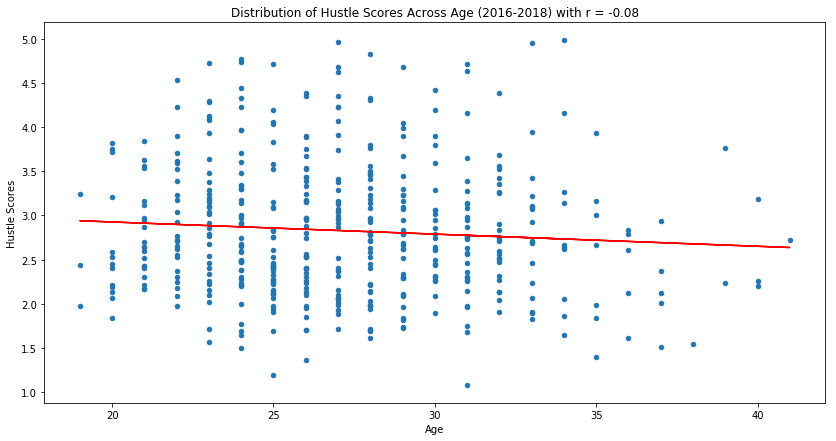

In [118]:
scatter = hustleStats.plot.scatter('AGE', 'HustleScore')

(m, b) = np.polyfit(hustleStats['AGE'], hustleStats['HustleScore'], 1)
# Calculate the actual best fit line 
regression_line = [(m*x)+b for x in hustleStats['AGE']]
scatter.plot(hustleStats['AGE'], regression_line, color='red') 
correlation = np.corrcoef(hustleStats['HustleScore'], hustleStats['AGE'])[0,1]

# Label the plot
scatter.set_title("Distribution of Hustle Scores Across Age (2016-2018) with r = " + str(round(correlation,2)))

# Label the plot
#scatter.set_title("Distribution of Hustle Scores Across Age (2016-2018) with (m, b) = (" + str(round(m,2)) + ", " + str(round(b, 2)) + ")")
scatter.set_xlabel("Age")
scatter.set_ylabel("Hustle Scores")

The above plot shows a slight negative correlation between age and hustle scores.  That is to say that as a player's age increases, a player's hustle score generally decreases slightly. 

### Minutes Played v Hustle Score
We posit that players who play more minutes hustle more.

Text(0, 0.5, 'Hustle Scores')

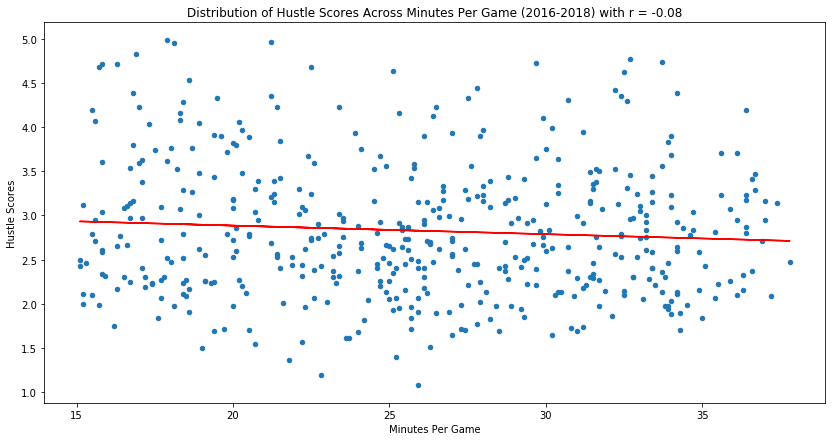

In [119]:
scatter = hustleStats.plot.scatter('MIN', 'HustleScore')

(m, b) = np.polyfit(hustleStats['MIN'], hustleStats['HustleScore'], 1)
# Calculate the actual best fit line 
regression_line = [(m*x)+b for x in hustleStats['MIN']]
scatter.plot(hustleStats['MIN'], regression_line, color='red') 

correlation = np.corrcoef(hustleStats['HustleScore'], hustleStats['MIN'])[0,1]

# Label the plot
scatter.set_title("Distribution of Hustle Scores Across Minutes Per Game (2016-2018) with r = " + str(round(correlation,2)))

# Label the plot
# scatter.set_title("Distribution of Hustle Scores Across Minutes Per Game (2016-2018) with (m, b) = (" + str(round(m,2)) + ", " + str(round(b, 2)) + ")")
scatter.set_xlabel("Minutes Per Game")
scatter.set_ylabel("Hustle Scores")

The above plot shows a slight negative correlation between minutes per game played and hustle scores.  That is to say that as a player's minutes per game increases, a player's hustle score generally decreases slightly. 

### Wins vs Team Hustle Score
We posit that teams hustle more have more wins.

In [120]:
teamHustleTable = pd.DataFrame(hustleStats.groupby(['Team', 'year'])['HustleScore'].sum())
teamHustleTable = teamHustleTable.sort_values(by=['HustleScore'],ascending=False)
teamHustleTable = teamHustleTable.reset_index()
teamHustleTable.head()

,Team,year,HustleScore
0,TOR,2017-18,32.684927
1,HOU,2016-17,32.453697
2,ATL,2016-17,29.289549
3,OKC,2017-18,29.115301
4,SAS,2016-17,28.576020


In [121]:
teamTable = pd.merge(teamHustleTable, teamWinsTable, on=['Team', 'year'])
teamTable.head()

,Team,year,HustleScore,Wins
0,TOR,2017-18,32.684927,59
1,HOU,2016-17,32.453697,55
2,ATL,2016-17,29.289549,43
3,OKC,2017-18,29.115301,48
4,SAS,2016-17,28.576020,61


Text(0, 0.5, 'Team Wins')

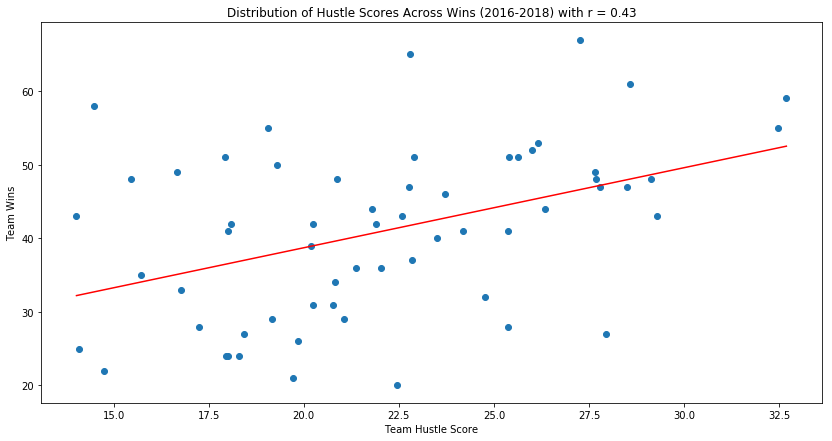

In [122]:
# Convert type of wins column to int32 because cannot be of object type when plotting 
teamTable['Wins'] = teamTable['Wins'].astype('int32')
x = teamTable['HustleScore']
y = teamTable['Wins']
fig, ax = plt.subplots()
ax.scatter(x, y) 

# Get the slope and intercept for the best fit line 
(m, b) = np.polyfit(teamTable['HustleScore'], teamTable['Wins'], 1)
# Calculate the actual best fit line 
regression_line = [(m*x)+b for x in teamTable['HustleScore']]
ax.plot(teamTable['HustleScore'], regression_line, color='red') 

correlation = np.corrcoef(teamTable['HustleScore'], teamTable['Wins'])[0,1]

# Label the plot
ax.set_title("Distribution of Hustle Scores Across Wins (2016-2018) with r = " + str(round(correlation,2)))

# Label the plot
#ax.set_title("Distribution of Hustle Scores Across Team Wins (2016-2018) with (m, b) = (" + str(round(m,2)) + ", " + str(round(b, 2)) + ")")
ax.set_xlabel("Team Hustle Score")
ax.set_ylabel("Team Wins")

The above plot shows a positive correlation between team wins and hustle scores.  That is to say that as a team's wins  increases, a team's hustle score generally increases. 

### Position v Hustle Score
We posit that some positions might have a higher hustle score than others.

Text(0.5, 1.0, 'Distribution of Position Across Hustle Score (2016-2018)')

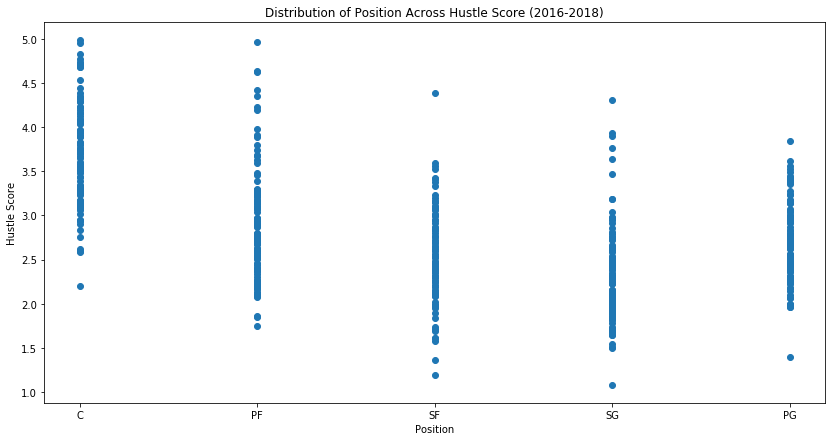

In [123]:
x = hustleStats['Pos']
y = hustleStats['HustleScore']
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel("Position")
ax.set_ylabel("Hustle Score")
ax.set_title("Distribution of Position Across Hustle Score (2016-2018)")

As seen in the above plot, there is a correlation between hustle score and position. This might be because some positions are more likely to assist, deflect or take contested shots than others, leading to a higher hustle score.

### Distinction Between the Top Hustle Score Teams and the Bottom Hustle Score Teams
We think that there might be a difference in hustle score between bottom and top teams. This might be that top teams hustle more because they have more wins, or that bottom teams hustle more because they are more desparate for points.

In [145]:
# Define a top team as having more than or equal to the median wins 
# and more than or equal to the median HustleScore
topTeams = teamTable[teamTable['Wins'] >= 48]
topTeams = topTeams.rename(index=str, columns={'HustleScore': 'TeamHustleScore'})
topTeams = topTeams[topTeams['TeamHustleScore'] >= topTeams['TeamHustleScore'].median()]
topTeams.head()

,Team,year,TeamHustleScore,Wins
0,TOR,2017-18,32.684927,59
1,HOU,2016-17,32.453697,55
3,OKC,2017-18,29.115301,48
4,SAS,2016-17,28.576020,61
8,IND,2017-18,27.676405,48


In [146]:
# Define a bottom team as having less than the median wins and less than the median HustleScore
bottomTeams = teamTable[teamTable['Wins'] < 48]
bottomTeams = bottomTeams.rename(index=str, columns={'HustleScore': 'TeamHustleScore'})
bottomTeams = bottomTeams[bottomTeams['TeamHustleScore'] < bottomTeams['TeamHustleScore'].median()]
bottomTeams.head()

,Team,year,TeamHustleScore,Wins
34,NOP,2016-17,20.808422,34
35,MIN,2016-17,20.777928,31
36,LAC,2017-18,20.250772,42
37,NYK,2016-17,20.239090,31
38,DET,2017-18,20.201732,39


In [147]:
topTeamsPlayers = pd.merge(topTeams, hustleStats, how='left', on=['Team']).sort_values('Pos')
bottomTeamsPlayers = pd.merge(bottomTeams, hustleStats, how='left', on=['Team']).sort_values('Pos')

Text(0, 0.5, 'HustleScore')

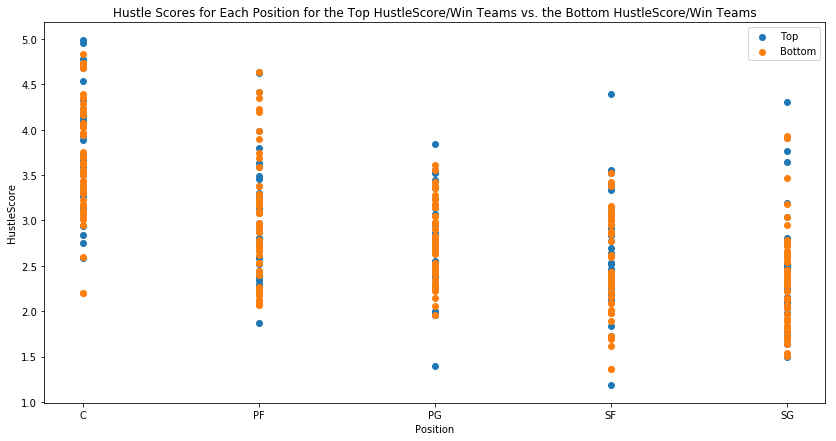

In [148]:
x1 = topTeamsPlayers['Pos']
y1 = topTeamsPlayers['HustleScore']

x2 = bottomTeamsPlayers['Pos']
y2 = bottomTeamsPlayers['HustleScore']

fig, ax = plt.subplots()
ax.scatter(x1, y1, label='Top')
ax.scatter(x2, y2, label='Bottom')

ax.legend()
ax.set_title('Hustle Scores for Each Position for the Top HustleScore/Win Teams vs. the Bottom HustleScore/Win Teams')
ax.set_xlabel('Position')
ax.set_ylabel('HustleScore')

As seen in the scatterplot above, there doesn't seem to be any great distinction between the top teams in the bottom teams in terms of the performance of each position. Small Forward, however, does show a slightly higher HustleScore in teams that have higher overall HustleScores and win more, potentially suggesting that that position may be motivated by the wins to try harder.

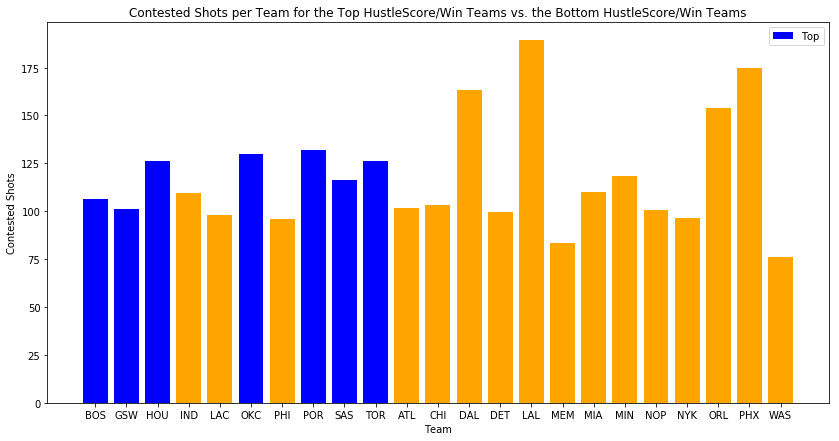

In [149]:
topContestedSums = topTeamsPlayers[['Team','ContestedShots']]
topContestedSums = topContestedSums.groupby(['Team']).sum()
topContestedSums['Standing'] = 'b'

bottomContestedSums = bottomTeamsPlayers[['Team', 'ContestedShots']]
bottomContestedSums = bottomContestedSums.groupby(['Team']).sum()
bottomContestedSums['Standing'] = 'orange'

contestedSums = topContestedSums.append(bottomContestedSums)
plt.bar(contestedSums.index, contestedSums['ContestedShots'], color=contestedSums.Standing)

plt.title('Contested Shots per Team for the Top HustleScore/Win Teams vs. the Bottom HustleScore/Win Teams')
plt.xlabel('Team')
plt.ylabel('Contested Shots')
#todo broken legend
plt.gca().legend(('Top', 'Bottom'))

We expected a losing team to take more shots contested shots due to being more desperate, but the data shows that there is no general trend when relating contested shots and temas with higher or lower hustle scores and wins.

### Salary v Hustle Score
We explore if teams pay more for players that hustle.

In [129]:
salaryHustle = pd.merge(hustleStats, salaryTable, on=['Player', 'year'], how='inner')
salaryHustle.head()

,Player,Team,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos,OREB,STL,HustleScore,salary
0,Gorgui Dieng,MIN,28,79,16.9,1.7,1.3,0.8,0.18,4.9,1.8,6.7,2017-18,C,1.3,0.6,4.832733,14112360
1,Steven Adams,OKC,24,76,32.7,4.9,2.3,1.4,0.00,9.6,3.8,13.4,2017-18,C,5.1,1.2,4.774576,22471910
2,Andre Drummond,DET,24,78,33.7,4.7,3.2,1.2,0.01,9.2,2.0,11.2,2017-18,C,5.1,1.5,4.735898,23775506
3,Amir Johnson,PHI,31,74,15.8,2.5,1.0,0.7,0.08,4.7,0.8,5.5,2017-18,C,1.7,0.6,4.716035,11000000
4,Ersan Ilyasova,PHI,31,69,25.1,1.8,1.7,0.9,0.46,4.6,2.2,6.8,2017-18,PF,1.7,0.9,4.637077,6000000


Text(0.5, 1.0, 'Distribution of Hustle Scores Across Salary (2016-2018) with r = 0.07')

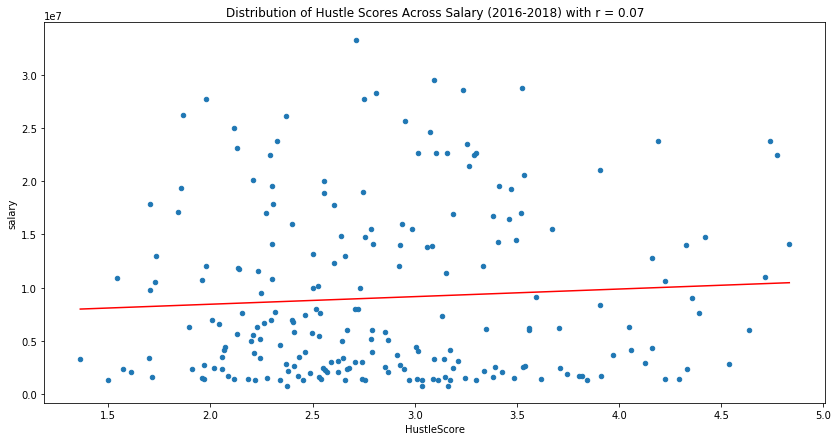

In [130]:
scatter = salaryHustle.plot.scatter('HustleScore', 'salary')

(m, b) = np.polyfit(salaryHustle['HustleScore'], salaryHustle['salary'], 1)
# Calculate the actual best fit line 
regression_line = [(m*x)+b for x in salaryHustle['HustleScore']]
scatter.plot(salaryHustle['HustleScore'], regression_line, color='red') 
correlation = np.corrcoef(salaryHustle['HustleScore'], salaryHustle['salary'])[0,1]

# Label the plot
scatter.set_title("Distribution of Hustle Scores Across Salary (2016-2018) with r = " + str(round(correlation,2)))

## Part 5: Predicting Points Per Game

Get table with all the hustle stats and the points for each player for linear regression.

In [131]:
hustleStatsWithPTS = hustleStats.merge(regularStats[['Player', 'PTS', 'year']], on=['Player', 'year'], how='left')
hustleStatsWithPTS = hustleStatsWithPTS.dropna()
hustleStatsWithPTS = hustleStatsWithPTS.sort_values(by=['year', 'PTS'], ascending=False)
hustleStatsWithPTS.head()

,Player,Team,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos,OREB,STL,HustleScore,PTS
209,James Harden,HOU,28,72,35.4,0.3,2.9,1.3,0.03,4.4,3.1,7.6,2017-18,SG,0.6,1.8,2.808241,30.4
30,Anthony Davis,NOP,25,75,36.4,3.9,2.4,1.5,0.15,9.8,4.5,14.3,2017-18,PF,2.5,1.5,4.190727,28.1
235,LeBron James,CLE,33,82,36.9,1.0,2.2,1.1,0.15,4.0,3.0,7.0,2017-18,PF,1.2,1.4,2.713628,27.5
111,Giannis Antetokounmpo,MIL,23,75,36.7,1.4,2.5,1.8,0.00,6.6,3.7,10.3,2017-18,PF,2.1,1.5,3.290717,26.9
325,Damian Lillard,POR,27,73,36.6,0.2,1.8,1.7,0.11,2.8,1.9,4.7,2017-18,PG,0.8,1.1,2.371984,26.9


### Step 1: Player Point Prediction based on Base Hustle Scores
We try to predict how many points a player gets based on his base hustle stats, where base hustle stats are the individual statistics from the NBA's website that we used to calculate our hustle score.

In [132]:
baseHustleReg = LinearRegression()
baseHustleReg = baseHustleReg.fit(hustleStatsWithPTS[['ScreenAssists', 'Deflections', 'Loose BallsRecovered', 'ChargesDrawn', 'ContestedShots']], hustleStatsWithPTS['PTS'])

In [133]:
hustleStatsWithPTS['residuals'] = hustleStatsWithPTS['PTS'] - baseHustleReg.predict(hustleStatsWithPTS[['ScreenAssists', 'Deflections', 'Loose BallsRecovered', 'ChargesDrawn', 'ContestedShots']])

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Residuals for predictions of points per game per player based on hustle stats by team')

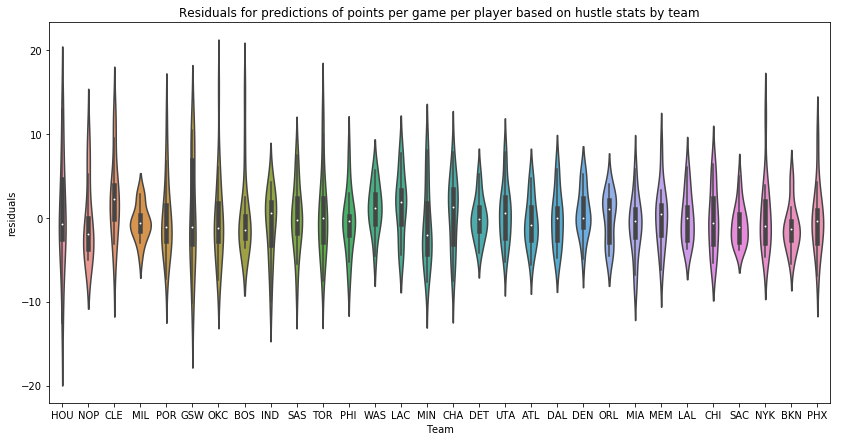

In [134]:
baseHustleViolin = sns.violinplot(x="Team", y="residuals", data=hustleStatsWithPTS)
baseHustleViolin.set_title("Residuals for predictions of points per game per player based on hustle stats by team")

In the above plot we see residuals of our predictive model. Ideally we want want the widest part of each violin to be closest to zero. This is true for some teams (e.g. CLE, DET, DEN, CHI, etc.). However, many teams have very high residuals, and have very thin violins, showing that for many of their players the base hustle stats don't effectively predict the number of points they score in a game.

### Step 2: Player Point Prediction based on Calculated Hustle Score
We then try to predict the number of points each player scores per game based on our calculated hustle score. We postulate that the results of this regression will be better because in our hustle score we standardized each parameter. This is different from Part 1 becuase in Part 1 we took raw hustle scores without standardization.

In [135]:
hustleReg = LinearRegression()
hustleReg.fit(hustleStatsWithPTS[['HustleScore']],hustleStatsWithPTS['PTS'])
hustleStatsWithPTS['hustleResidual'] = hustleStatsWithPTS['PTS'] - hustleReg.predict(hustleStatsWithPTS[['HustleScore']])

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Residuals for calculated hustles score predictive model by team')

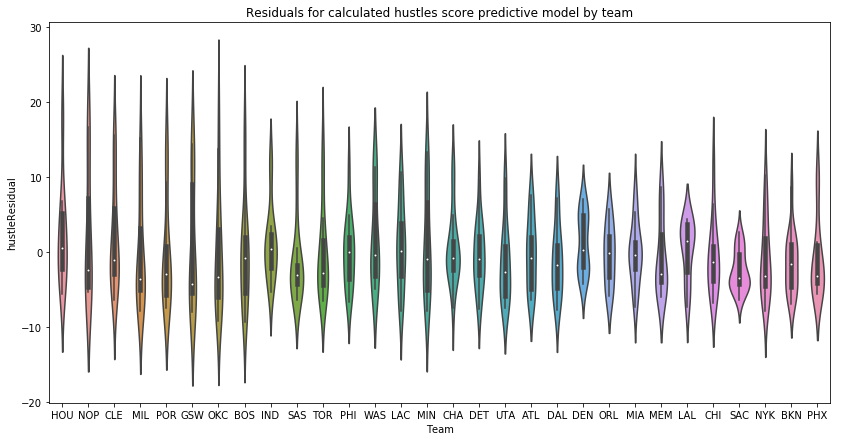

In [136]:
hustleViolin = sns.violinplot(x="Team", y="hustleResidual", data=hustleStatsWithPTS)
hustleViolin.set_title("Residuals for calculated hustles score predictive model by team")

We see higher residuals in this plot than in the previous one. This could be because our hustle score doesn't predict points well.

### Step 3: Using the regular statistics to predict player points

In [137]:
# Merge the team column into the regular stats table
regularStatsWithTeam = regularStats.merge(hustleStats[['Player', 'Team', 'year']], on=['Player', 'year']).drop(['#'], axis=1)
#regularStatsWithWins = regularStatsWithWins.groupby(['Team']).sum().merge(teamTable, on=['Team'])
regularStatsWithTeam = regularStatsWithTeam.drop(['GP', 'MIN'], axis=1)
regularStatsWithTeam.head()

,Player,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,...,OREB,DREB,REB,AST,STL,BLK,TOV,EFF,year,Team
0,Russell Westbrook,31.6,10.2,24.0,42.5,2.5,7.2,34.3,8.8,10.4,...,1.7,9.0,10.7,10.4,1.6,0.4,5.4,33.8,2016-17,OKC
1,James Harden,29.1,8.3,18.9,44.0,3.2,9.3,34.7,9.2,10.9,...,1.2,7.0,8.1,11.2,1.5,0.5,5.7,32.4,2016-17,HOU
2,Isaiah Thomas,28.9,9.0,19.4,46.3,3.2,8.5,37.9,7.8,8.5,...,0.6,2.1,2.7,5.9,0.9,0.2,2.8,24.7,2016-17,BOS
3,Anthony Davis,28.0,10.3,20.3,50.5,0.5,1.8,29.9,6.9,8.6,...,2.3,9.5,11.8,2.1,1.3,2.2,2.4,31.1,2016-17,NOP
4,DeMar DeRozan,27.3,9.7,20.9,46.7,0.4,1.7,26.6,7.4,8.7,...,0.9,4.3,5.2,3.9,1.1,0.2,2.4,22.7,2016-17,TOR


In [138]:
regularStatsReg = LinearRegression()
regularStatsReg.fit(regularStatsWithTeam[['REB', 'AST', 'STL', 'BLK', 'TOV']], regularStatsWithTeam['PTS'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


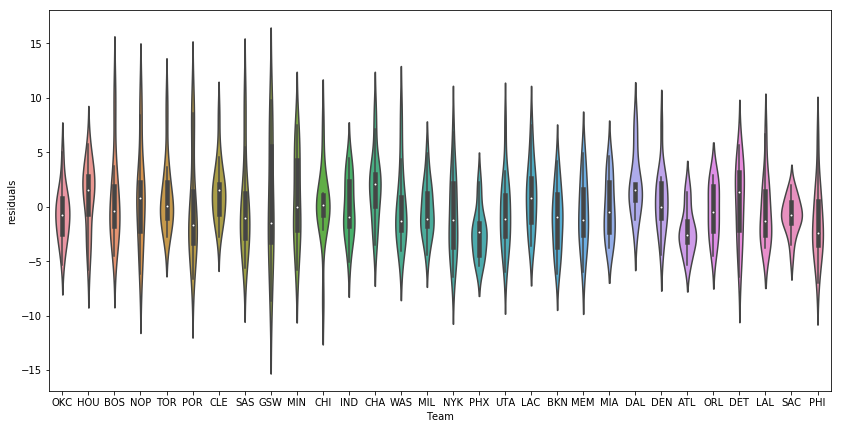

In [139]:
regularStatsWithTeam['residuals'] = regularStatsWithTeam['PTS'] - regularStatsReg.predict(regularStatsWithTeam[['REB', 'AST', 'STL', 'BLK', 'TOV']])
violin = sns.violinplot(x="Team", y="residuals", data=regularStatsWithTeam)

The above plot shows the prediction of each player's points based solely on their standard statistics per team. As with our earlier plot, some player's statistics are predicted really well by their regular stats, while others are not.

### Step 4: Incorporating the Hustle Score

In [140]:
# Merge calculated hustle stat into regular stats table
allStats = regularStatsWithTeam.merge(hustleStats[['Player', 'year', 'HustleScore']], on=['Player', 'year'])
allStats = allStats.dropna()
allStats.head()

,Player,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,...,REB,AST,STL,BLK,TOV,EFF,year,Team,residuals,HustleScore
0,Russell Westbrook,31.6,10.2,24.0,42.5,2.5,7.2,34.3,8.8,10.4,...,10.7,10.4,1.6,0.4,5.4,33.8,2016-17,OKC,-2.489042,2.773719
1,James Harden,29.1,8.3,18.9,44.0,3.2,9.3,34.7,9.2,10.9,...,8.1,11.2,1.5,0.5,5.7,32.4,2016-17,HOU,-5.786434,2.866732
2,Isaiah Thomas,28.9,9.0,19.4,46.3,3.2,8.5,37.9,7.8,8.5,...,2.7,5.9,0.9,0.2,2.8,24.7,2016-17,BOS,10.919020,1.975801
3,Anthony Davis,28.0,10.3,20.3,50.5,0.5,1.8,29.9,6.9,8.6,...,11.8,2.1,1.3,2.2,2.4,31.1,2016-17,NOP,8.416186,3.703684
4,DeMar DeRozan,27.3,9.7,20.9,46.7,0.4,1.7,26.6,7.4,8.7,...,5.2,3.9,1.1,0.2,2.4,22.7,2016-17,TOR,10.038004,2.061284


In [141]:
# Perform the same regression as earlier but with the added hustle score column
hustleRegularStatsReg = LinearRegression()
hustleRegularStatsReg.fit(allStats[['REB', 'AST', 'STL', 'BLK', 'TOV', 'HustleScore']], allStats['PTS'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Residuals of predictive model using regular statistics with hustle score')

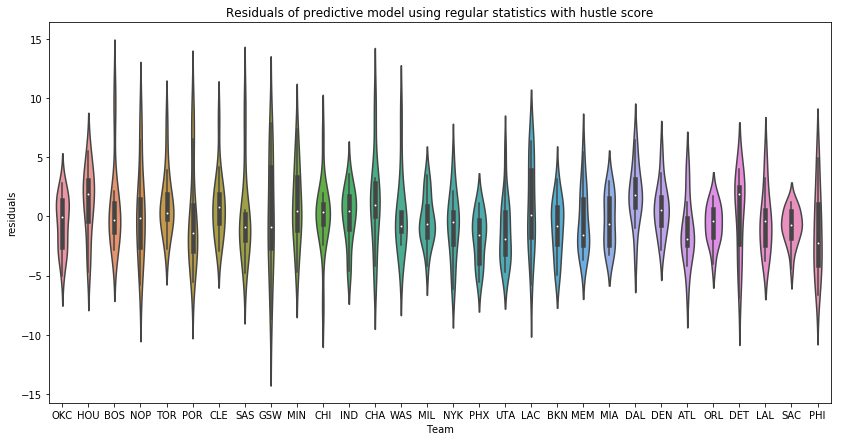

In [142]:
allStats['residuals'] = allStats['PTS'] - hustleRegularStatsReg.predict(allStats[['REB', 'AST', 'STL', 'BLK', 'TOV', 'HustleScore']])
violin = sns.violinplot(x="Team", y="residuals", data=allStats)
violin.set_title("Residuals of predictive model using regular statistics with hustle score")

As we see here, the hustle score slightly improves the player points per game prediction.

## Part 6: Predicting Wins
We first try to see if points predict wins.

In [143]:
hustleStatsWithWins = hustleStats.groupby(['Team', 'year']).sum().merge(teamWinsTable, on=['Team', 'year'])
hustleWinsReg = LinearRegression()
hustleWinsReg.fit(hustleStatsWithWins[['HustleScore']], hustleStatsWithWins['Wins'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

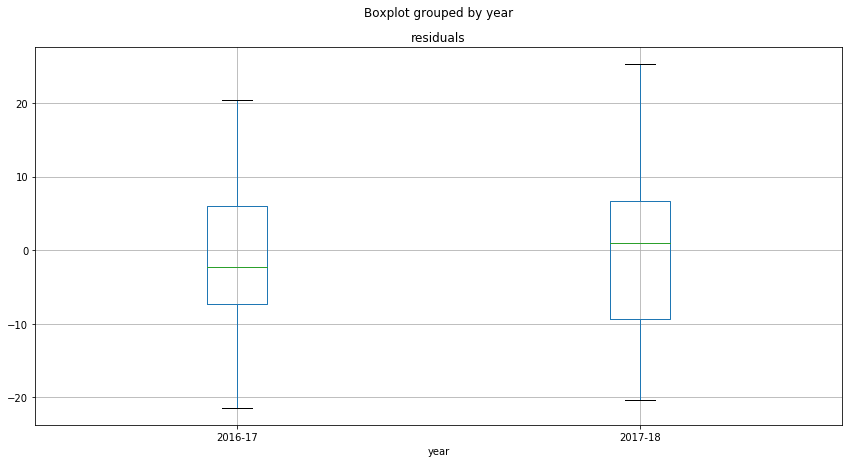

In [144]:
hustleStatsWithWins['residuals'] = hustleStatsWithWins['Wins'] - hustleWinsReg.predict(hustleStatsWithWins[['HustleScore']])
hustleStatsWithWins.boxplot(column=['residuals'], by='year')

As seen in the plot above, hustle score does an OK job of predicting wins for a team, especially in 2016-17.

In [153]:
topTeams['TeamHustleScore'].median()

27.659860180325744

In [154]:
bottomTeams['TeamHustleScore'].median()

18.186416322335806